In [1]:
#Automated reloading of custom modules
%load_ext autoreload
%autoreload 2

In [3]:
#Standard modules
import os
import time
import numpy as np
import scipy
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
from datetime import datetime

#Custom modules
import helpers as hlp
import models as mdl

# Check avaibale device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Used device: {}.".format(DEVICE))

Used device: cpu.


### Reproductability

In [4]:
SEED = 12345
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Parameters
Implemented datasets:
- MNIST:
- CIFAR10:

In [12]:
#Dataset
DATASET = "CIFAR100" 
MODEL = "lenet5" # 'fc', 'resnet18', 'lenet5'
REDUCED = False
FLATTEN = True if MODEL == "fc" else False

#Collaborative learning
N_CLIENTS = 2
SIZES = None # None for uniform sizes or array of length N_CLIENTS using all the data
ALPHA = "uniform" #'uniform', 'disjoint' or postive.
#Communication topology. Tij = 1 means i uses Xj and Yj for the KD
#TOPOLOGY = [[0, 1, 0, 0], 
#            [0, 0, 1, 0],
#            [0, 0, 0, 1],
#            [1, 0, 0, 0]]
TOPOLOGY = [[0, 1],
            [1, 0]]

#Learning
BATCH_SIZE = 16
BATCH_SIZE_KD = 16
ROUNDS = 50
EPOCHS_PER_ROUND = 1
EPOCHS_PER_ROUND_KD = 1
RANDOM_SAMPLES = 1000
CRITERION = nn.CrossEntropyLoss()
CRITERION_KD = nn.MSELoss() #loss for knowledge diffusion
N_EVAL = 1 #Evaluate train and test performace after N_EVAL epochs

#Directories
DATE = datetime.now()
EXPORT_DIR = "./saves/Experiments/" + DATE.strftime("%d-%m-%Y/%H-%M-%S")
#os.makedirs(EXPORT_DIR, exist_ok=True)
#
## Store parameters
#with open(EXPORT_DIR + "/metadata.txt", 'w') as f:
#    f.write("Parameter of the experiment conducted the {} at {}.\n\n".format(DATE.strftime("%d/%m/%Y"),
#                                                                             DATE.strftime("%H:%m:%Y")))
#    f.write("Model architecture:       {}\n".format(MODEL))
#    f.write("Dataset:                  {}\n".format(DATASET))
#    f.write("Reduced:                  {}\n".format(REDUCED))
#    f.write("Number of clients:        {}\n".format(N_CLIENTS))
#    f.write("Dataset sizes:            {}\n".format("uniform" if SIZES is None else SIZES))
#    f.write("Concentration (alpha):    {}\n".format(ALPHA))
#    f.write("Topology:                 {}\n".format(TOPOLOGY))
#    f.write("Communication rounds:     {}\n".format(ROUNDS))
#    f.write("Epoch per round:          {}\n".format(EPOCHS_PER_ROUND))
#    f.write("Batch size:               {}\n".format(BATCH_SIZE))
#    f.write("Criterion:                {}\n".format(type(CRITERION)))
#    f.write("Number of random samples: {}\n".format(RANDOM_SAMPLES))
#    f.write("Epoch per round (KD):     {}\n".format(EPOCHS_PER_ROUND_KD))
#    f.write("Batch size (KD):          {}\n".format(BATCH_SIZE_KD))
#    f.write("Criterion (KD):           {}\n".format(type(CRITERION_KD)))
#    f.write("Seed:                     {}\n".format(SEED))

### Data loadiing

** Using CIFAR **
Load train data...
Files already downloaded and verified
Load validation data...
Files already downloaded and verified
Dataset sizes:
	- Train: (50000, 3, 32, 32)
	- Validation (10000, 3, 32, 32)


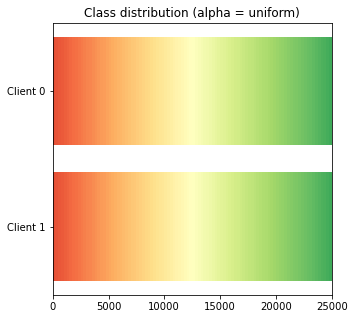

In [14]:
# Load dataset
train_input, train_target, val_input, val_target, meta = hlp.load_data(dataset=DATASET,
                                                                       reduced=REDUCED, 
                                                                       flatten=FLATTEN,
                                                                       device=DEVICE)

#Create custom torch datasets
train_ds = hlp.CustomDataset(train_input, train_target)
val_ds = hlp.CustomDataset(val_input, val_target)

#Split dataset
#train_ds_list = hlp.split_dataset_randomly(train_ds, SIZES)
#val_ds_list = hlp.split_dataset_randomly(val_ds, SIZES)
train_ds_list, val_ds_list = hlp.split_dataset(N_CLIENTS, train_ds, val_ds, ALPHA, SIZES)

#Create dataloader
train_dl_list = hlp.ds_to_dl(train_ds_list, batch_size=BATCH_SIZE)
val_dl_list = hlp.ds_to_dl(val_ds_list)


#Visualize partition
hlp.visualize_class_dist(train_ds_list, meta["n_class"], title="Class distribution (alpha = {})".format(ALPHA),savepath=None)

### Model initialization

In [52]:
# Model initialization
if MODEL == "fc":
    client_models = [mdl.FC_Net(meta["in_dimension"][0], meta["n_class"]).to(DEVICE) for _ in range(N_CLIENTS)]
    client_models_kd = [mdl.FC_Net(meta["in_dimension"][0], meta["n_class"]).to(DEVICE) for _ in range(N_CLIENTS)]
    model_fl = mdl.FC_Net(meta["in_dimension"][0], meta["n_class"]).to(DEVICE)
    client_models_fl = [mdl.FC_Net(meta["in_dimension"][0], meta["n_class"]).to(DEVICE) for _ in range(N_CLIENTS)]

elif MODEL == "resnet18":
    client_models = [mdl.ResNet18(meta["in_dimension"][0], meta["n_class"]).to(DEVICE) for _ in range(N_CLIENTS)]
    client_models_kd = [mdl.ResNet18(meta["in_dimension"][0], meta["n_class"]).to(DEVICE) for _ in range(N_CLIENTS)]
    model_fl = mdl.ResNet18(meta["in_dimension"][0], meta["n_class"]).to(DEVICE)
    client_models_fl = [mdl.ResNet18(meta["in_dimension"][0], meta["n_class"]).to(DEVICE) for _ in range(N_CLIENTS)]
    
elif MODEL == "lenet5":
    client_models = [mdl.LeNet5(meta["in_dimension"][0], meta["n_class"]).to(DEVICE) for _ in range(N_CLIENTS)]
    client_models_kd = [mdl.LeNet5(meta["in_dimension"][0], meta["n_class"]).to(DEVICE) for _ in range(N_CLIENTS)]
    model_fl = mdl.LeNet5(meta["in_dimension"][0], meta["n_class"]).to(DEVICE)
    client_models_fl = [mdl.LeNet5(meta["in_dimension"][0], meta["n_class"]).to(DEVICE) for _ in range(N_CLIENTS)]
    
# Performance tracker
perf_trackers = [hlp.PerfTracker(client_models[i], {"Train": train_dl_list[i], "Validation": val_dl_list[i]}, 
                                 CRITERION, meta["n_class"], 
                                 EXPORT_DIR + "/client_{}".format(i), ID="Client {}".format(i)) for i in range(N_CLIENTS)]
perf_trackers_kd = [hlp.PerfTracker(client_models_kd[i], {"Train": train_dl_list[i], "Validation": val_dl_list[i]}, 
                                    CRITERION, meta["n_class"], 
                                    EXPORT_DIR + "/client_{}_KD".format(i), ID="Client {} (KD)".format(i)) for i in range(N_CLIENTS)]

perf_trackers = [hlp.PerfTracker(model_fl, {"Train": train_dl_list[i], "Validation": val_dl_list[i]}, 
                                    CRITERION, meta["n_class"], 
                                    EXPORT_DIR + "/client_{}_FL".format(i), ID="Client {} (FL)".format(i)) for i in range(N_CLIENTS)]

### Traditional (spearated) learning

In [33]:
#Each client updates its model locally on its own dataset (Standard)
for client_id in range(N_CLIENTS):
    #Setting up the local training
    model = client_models[client_id]
    optimizer = torch.optim.Adam(model.parameters())
    model.train()

    #Local update
    t_tot = 0
    for e in range(ROUNDS*EPOCHS_PER_ROUND):
        t0 = time.time()
        for features, target in train_dl_list[client_id]:
            optimizer.zero_grad()
            output = model(features)
            loss = CRITERION(output, target)
            loss.backward()
            optimizer.step()
        t1 = time.time()
        
        #Tracking performance
        if e % N_EVAL == 0:
            perf_trackers[client_id].new_eval(index=e)
        t2 = time.time()
        print("\rClient {}: epoch {}/{} done (Training time: {:.1f}s, Evaluation time: {:.1f}s).".format(client_id, e+1, ROUNDS*EPOCHS_PER_ROUND, t1-t0, t2-t1), end="  ")
        t_tot += t2-t0
    print("\nClient {} done. ({:.1f}s)".format(client_id, t_tot))    

NameError: name 'client_models' is not defined

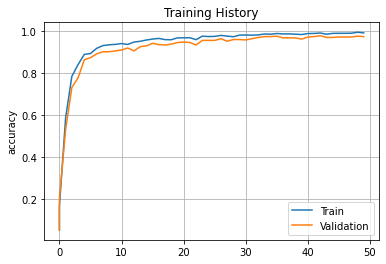

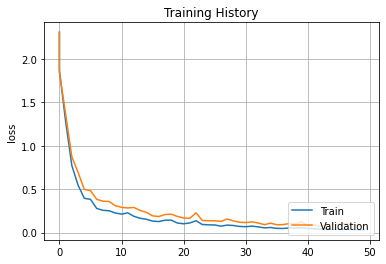

In [22]:
# Visualization of training history
user = 1
perf_trackers[user].plot_training_history(metric="accuracy")
perf_trackers[user].plot_training_history(metric="loss")

### Learning with random KD

Communication round 50/50 done.                                                    

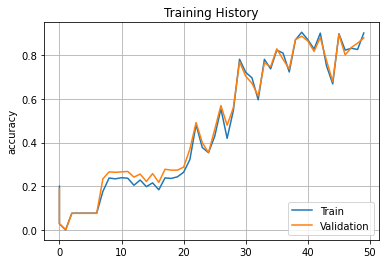

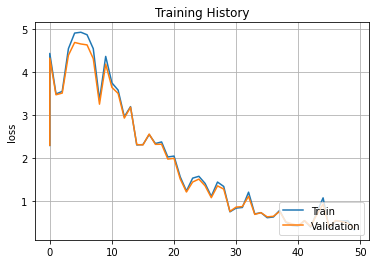

In [23]:
#Training phase
for r in range(ROUNDS):
    
    #######################################################################
    #Each client updates its model locally on its own dataset
    for client_id in range(N_CLIENTS):
        
        #Setting up the local training
        model = client_models_kd[client_id]
        optimizer = torch.optim.Adam(model.parameters())
        model.train()
        
        #Local update
        for e in range(EPOCHS_PER_ROUND):
            for features, target in train_dl_list[client_id]:
                optimizer.zero_grad()
                output = model(features)
                loss = CRITERION(output, target)
                loss.backward()
                optimizer.step()
        print("\rRound {}/{}: Local update of client {} done.".format(r+1, ROUNDS, client_id), end=40*" ")
    
    # Blind learning (creation of input/output pairs)
    features_rand = torch.normal(0, 1, size=(N_CLIENTS, RANDOM_SAMPLES, *meta["in_dimension"])).to(DEVICE)
    output_rand = torch.empty(N_CLIENTS, RANDOM_SAMPLES, meta["n_class"]).to(DEVICE)
    
    for client_id in range(N_CLIENTS):
        model = client_models_kd[client_id]
        model.eval()
        with torch.no_grad():
            output_rand[client_id] = model(features_rand[client_id])
    
    ds_kd_list = [hlp.CustomDataset(features_rand[i], output_rand[i]) for i in range(N_CLIENTS)]
    dl_kd_list = [hlp.ds_to_dl(ds, batch_size=BATCH_SIZE_KD) for ds in ds_kd_list]
    
    # Blind learning (knowledge diffusion)
    for client_id in range(N_CLIENTS):
        model = client_models_kd[client_id]
        optimizer = torch.optim.Adam(model.parameters())
        #model.train() #Should this be? maybe the dropout hinders the effect of KD
        
        for peer_id, isConsidered in enumerate(TOPOLOGY[client_id]):
            if isConsidered:
                for e in range(EPOCHS_PER_ROUND_KD):
                    for x_kd, y_kd in dl_kd_list[peer_id]:
                        optimizer.zero_grad()
                        y_kd_pers = model(x_kd)
                        loss = CRITERION_KD(y_kd_pers, y_kd)
                        loss.backward()
                        optimizer.step()
        #Tracking performance
        if r*EPOCHS_PER_ROUND % N_EVAL == 0:
            perf_trackers_kd[client_id].new_eval(index=r*EPOCHS_PER_ROUND)
        print("\rRound {}/{}: KD of client {} done.".format(r+1, ROUNDS, client_id), end=40*" ")
    print("\rCommunication round {}/{} done.".format(r+1, ROUNDS), end=40*" ")


# Visualization of training history
user = 0
perf_trackers_kd[user].plot_training_history(metric="accuracy")
perf_trackers_kd[user].plot_training_history(metric="loss")

### Federated Learning (FedAvg)

In [ ]:
for r in range(ROUNDS):    
    # Communicate server model to each client
    for client_id in range(N_CLIENTS):
        model = client_models[client_id]
        

### Comparison

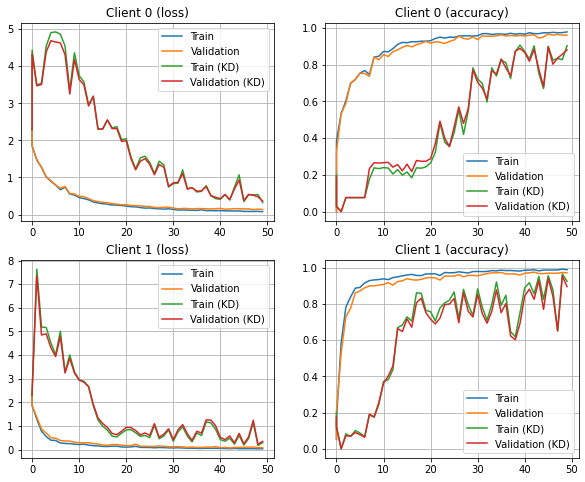

In [24]:
fig, axs = plt.subplots(N_CLIENTS, 2, figsize=(10, 4*N_CLIENTS))
for i in range(N_CLIENTS):

    pt = perf_trackers[i]
    pt_kd = perf_trackers_kd[i]
    axs[i,0].plot(pt.index, pt.perf_history_tr["loss"], label="Train")
    axs[i,0].plot(pt.index, pt.perf_history_val["loss"], label="Validation")
    axs[i,0].plot(pt_kd.index, pt_kd.perf_history_tr["loss"], label="Train (KD)")
    axs[i,0].plot(pt_kd.index, pt_kd.perf_history_val["loss"],label="Validation (KD)")
    axs[i,0].set_title("Client {} (loss)".format(i))
    axs[i,0].legend()
    axs[i,0].grid()
    
    
    axs[i, 1].plot(pt.index, np.trace(pt.perf_history_tr["confusion matrix"], axis1=1, axis2=2) / np.sum(pt.perf_history_tr["confusion matrix"], axis=(1,2)), label="Train")
    axs[i, 1].plot(pt.index, np.trace(pt.perf_history_val["confusion matrix"], axis1=1, axis2=2) / np.sum(pt.perf_history_val["confusion matrix"], axis=(1,2)), label="Validation")
    axs[i, 1].plot(pt_kd.index, np.trace(pt_kd.perf_history_tr["confusion matrix"], axis1=1, axis2=2) / np.sum(pt_kd.perf_history_tr["confusion matrix"], axis=(1,2)), label="Train (KD)")
    axs[i, 1].plot(pt_kd.index, np.trace(pt_kd.perf_history_val["confusion matrix"], axis1=1, axis2=2) / np.sum(pt_kd.perf_history_val["confusion matrix"], axis=(1,2)), label="Validation (KD)")
    axs[i, 1].set_title("Client {} (accuracy)".format(i))
    axs[i, 1].legend()
    axs[i, 1].grid()
    
    fig.savefig(EXPORT_DIR + "/train_history.png", bbox_inches='tight')

Check for the following
- model complexity
- check if performance improve by doing kd on all activation
- federated learing
- server with no data

topology
computation
security 
    learning theroy proble + sample complexity bounds
    show information leakage for every round

Non-iid conergence


### Convert to executable

In [14]:
# Convert to executable (without the Magic cells)
!jupyter nbconvert \
    --TagRemovePreprocessor.enabled=True \
    --TagRemovePreprocessor.remove_cell_tags 'Magic' \
    --TemplateExporter.exclude_markdown=True \
    --to python "BlindLearning.ipynb"


[NbConvertApp] Converting notebook BlindLearning.ipynb to python
[NbConvertApp] Writing 10602 bytes to BlindLearning.py


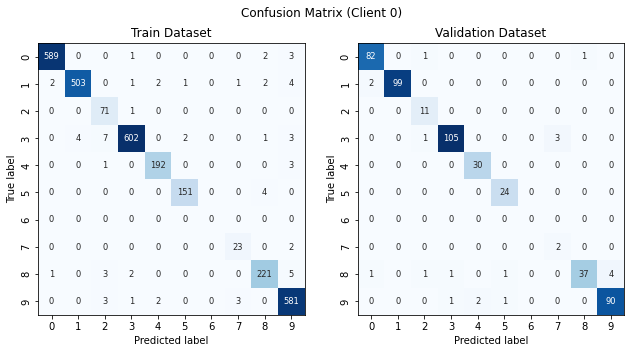

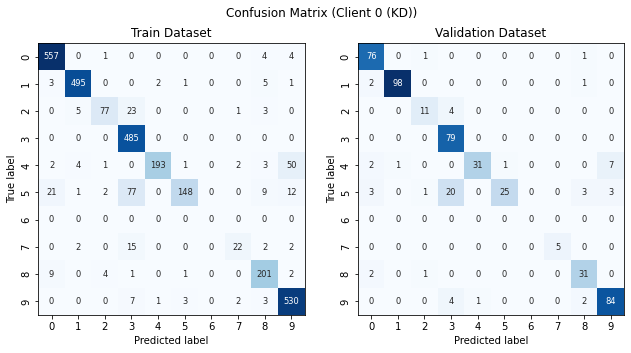

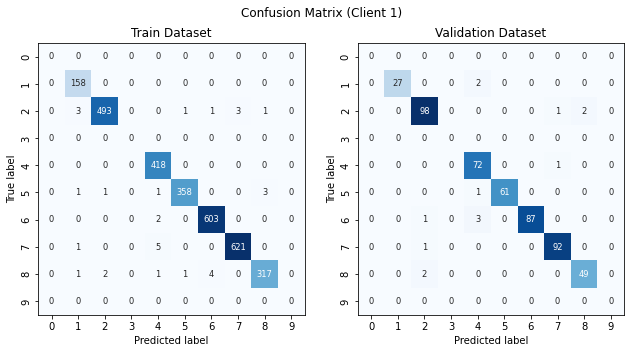

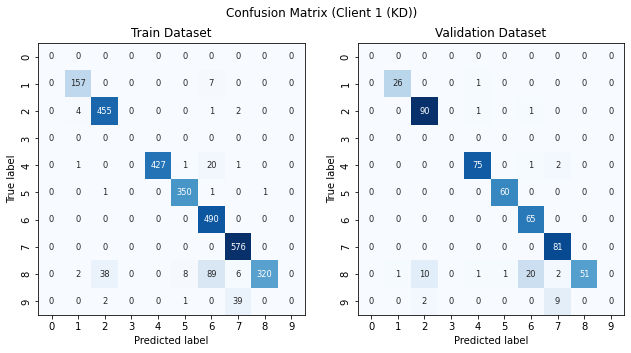

In [31]:
perf_trackers[0].plot_confusion_matrix()
perf_trackers_kd[0].plot_confusion_matrix()

perf_trackers[1].plot_confusion_matrix()
perf_trackers_kd[1].plot_confusion_matrix()

In [30]:
### Code developement

In [13]:
def foo(**kwargs):
    print(kwargs["lambda"])

In [31]:
np.ones(10) - np.eye(10)

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])

In [40]:
print(exp.get_model("CIFAR100"))

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
train_dl_list[0].dataset.len

25000